# KyFromAbove Explorer November Stats

This project takes data from an AWS Athena DataCatalog database table for the [KyFromAbove Open Data on AWS](https://registry.opendata.aws/kyfromabove/) from the [KyFromAbove Exploerer](https://explore.kyfromabove.ky.gov/) for the month of November.  For simplicity and security reasons, I performed the query in Athena and just exported the results to CSV.  This way, I'm not providing access information to AWS, plus not having to query, paginate, and refresh a token.  Even though these log files are public requests to publicly-available data, I ommited the fields `bucketowner` and `requester`.

```sql
    SELECT "bucket_name", "requestdatetime", "remoteip", "requestid", "operation", "key",
           "request_uri", "httpstatus", "errorcode", "bytessent", "objectsize", "totaltime", 
           "turnaroundtime", "referrer", "useragent", "hostid", "sigv", "ciphersuite", "authtype", "endpoint", 
           "tlsversion", "accesspointarn", "aclrequired", "year", "month"
    FROM "s3_access_logs_db"."kyfromabove_monthly"
    WHERE year = '2024'
        and month = '11'
```

Download the [CSV]( 'https://ky.box.com/shared/static/h55nx1ca7ztcuzqvf8tu4g5q48t6lmqk.csv') (4.18 GB) data file<br>
Download the [GZIP](https://ky.box.com/shared/static/i51gwqpefsgwyooodjtuy0ima6w8u6xg.gz) (667 MB) compressed csv data file.


___

## Project Questions

 - How many GET requests is the KyFromAbove S3 Bucket receiving from the KyFromAbove Explorer.
 - How many bytes are getting sent?
 - What are the most popular images?
 - Who is using the data?

___

## Read the data using pandas

In [1]:
# Install modules
# %pip install pandas
# %pip install matplotlib
# % pip install geopandas
# %pip install ipinfo
# %pip install folium

In [2]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import ipinfo
from shapely.geometry import Point

In [3]:
# add my csv file path
csv_file = './athena_output.csv'

# read as a dataframe
logs = pd.read_csv(
    csv_file, 
    header=0, 
    dtype=
    {'httpstatus': str,  # columns popped out as mixed Dtype
     'totaltime': str    # so I just assigned them as strings
                         # we can deal can deal with them later
    }
) 

# print a couple lines
logs.head(2)

,bucket_name,requestdatetime,remoteip,requestid,operation,key,request_uri,httpstatus,errorcode,bytessent,...,hostid,sigv,ciphersuite,authtype,endpoint,tlsversion,accesspointarn,aclrequired,year,month
0,kyfromabove,01/Nov/2024:01:06:01 +0000,205.204.186.53,QTJ7FBZE48QH5D8H,REST.GET.OBJECT,imagery/orthos/Phase3/KY_KYAPED_2022_Season2_3...,"""GET /imagery/orthos/Phase3/KY_KYAPED_2022_Sea...",206,-,8388608.0,...,rjNpjShwbo9kejjPpS7tb1qNc4gyrgM60SMJZ+M8Ljv2E0...,SigV4,ECDHE-RSA-AES128-GCM-SHA256,AuthHeader,kyfromabove.s3-accelerate.amazonaws.com,TLSv1.2,-,-,2024,11
1,kyfromabove,01/Nov/2024:00:52:13 +0000,205.204.186.53,ECTKE7FSKM0ZJAAX,REST.GET.OBJECT,imagery/orthos/Phase3/KY_KYAPED_2022_Season2_3...,"""GET /imagery/orthos/Phase3/KY_KYAPED_2022_Sea...",206,-,8388608.0,...,J++KLUf90CFdJgr1BnqftCHmgwr8BCRn3j33v7S1CbVG9L...,SigV4,ECDHE-RSA-AES128-GCM-SHA256,AuthHeader,kyfromabove.s3-accelerate.amazonaws.com,TLSv1.2,-,-,2024,11


#### Drop columns

In [4]:
# print columns
logs.columns

Index(['bucket_name', 'requestdatetime', 'remoteip', 'requestid', 'operation',
       'key', 'request_uri', 'httpstatus', 'errorcode', 'bytessent',
       'objectsize', 'totaltime', 'turnaroundtime', 'referrer', 'useragent',
       'versionid', 'hostid', 'sigv', 'ciphersuite', 'authtype', 'endpoint',
       'tlsversion', 'accesspointarn', 'aclrequired', 'year', 'month'],
      dtype='object')

to drop:

```sh

'bucket_name'  # all the same values
'requestid'    # obsure 
'request_uri'  #
'errorcode'    # most will be nulls
'useragent'    # would be neat but it doesn't mean a whole lot for this analysis
'versionid'    # obscure
'hostid'       # unnecesary
'sigv'         # for AWS governance
'ciphersuite'  # ""
'authtype'     # ""
'endpoint'     # Will all be the same once we filter 
'turnaroundtime' 
'tlsversion'   # aws 
'accesspointarn'  # aws
'aclrequired'  # aws
'year'         # partition info, not needed 
'month'        # partition info, not needed

```

I also know that I'm looking for requests that come from the KyFromAbove Explorer, so I will also filter the dataframe for values `referrer=https://explore.kyfromabove.ky.gov/`.  I'm also only looking for GET request.


In [5]:
# drop bucket_name, year, and month
logs = logs.drop(['bucket_name','requestid', 'request_uri', 'errorcode', 'turnaroundtime',
                  'useragent','versionid', 'hostid', 'sigv', 'ciphersuite', 'authtype', 'endpoint',
                  'tlsversion', 'accesspointarn', 'aclrequired', 'year', 'month'], axis=1)

# filter for the referrer and the GET requests
logs_filtered = logs[
    (logs['referrer'] == '"https://explore.kyfromabove.ky.gov/"') &
    (logs['operation'].str.contains('GET'))
]

# Print some info
print(f"The unfiltered dataset has this for it's shape value: {logs.shape}\n")
print(f'The total amount of GET requests for oblique imagery for November was {logs_filtered.shape[0]: ,}.\n')  # just to get an idea of the data

# drop a couple columns now that we've filtered
logs_filtered = logs_filtered.drop(['referrer', 'operation'], axis=1)

pd.options.display.float_format = '{:,.2f}'.format
logs_filtered.describe()

The unfiltered dataset has this for it's shape value: (6612895, 9)

The total amount of GET requests for oblique imagery for November was  1,833,992.



,bytessent,objectsize
count,"1,833,851.00","1,833,730.00"
mean,"102,337.34","101,727,325.87"
std,"40,875.12","63,242,133.67"
min,1.00,"16,225.00"
25%,"83,796.00","53,085,614.00"
50%,"113,088.00","84,032,917.00"
75%,"132,510.00","172,160,735.00"
max,"221,173.00","249,161,895.00"


In [6]:
# check the columns
logs_filtered.columns

Index(['requestdatetime', 'remoteip', 'key', 'httpstatus', 'bytessent',
       'objectsize', 'totaltime'],
      dtype='object')

___

## Data Cleaning and Preparation

In [7]:
# review column datatypes
print(logs_filtered.dtypes)

requestdatetime     object
remoteip            object
key                 object
httpstatus          object
bytessent          float64
objectsize         float64
totaltime           object
dtype: object


#### Convert columns to proper data types

In this section, I'm going to format the `requestdatetime` values so that it's just a day/month/year without a time stamp.

In [8]:
# convert timestamp to datetime object
logs_filtered['formatted_date'] = pd.to_datetime(logs_filtered['requestdatetime'], format='%d/%b/%Y:%H:%M:%S %z')
# Format the datetime objects to "Day/Month/Year"
logs_filtered['formatted_date'] = logs_filtered['formatted_date'].dt.strftime('%d/%m/%Y')

print(logs_filtered['formatted_date'])

28         01/11/2024
29         01/11/2024
30         01/11/2024
31         01/11/2024
32         01/11/2024
              ...    
6612291    30/11/2024
6612292    30/11/2024
6612892    30/11/2024
6612893    30/11/2024
6612894    30/11/2024
Name: formatted_date, Length: 1833992, dtype: object


#### Extract the file name from key variable

In [9]:
# get basefile name
logs_filtered['filename'] = logs_filtered['key'].apply(os.path.basename)
logs_filtered['filename'].head(5)

28    Color_6146_14210.tif
29    Color_6146_14210.tif
30    Right_6144_13341.tif
31     Color_3086_4179.tif
32     Color_3086_4179.tif
Name: filename, dtype: object

In [10]:
# review column datatypes
print(logs_filtered.dtypes)

requestdatetime     object
remoteip            object
key                 object
httpstatus          object
bytessent          float64
objectsize         float64
totaltime           object
formatted_date      object
filename            object
dtype: object


##### Convert totaltime to numeric columns

In [11]:
# Convert totaltime to numeric and explicitly cast to float
logs_filtered.loc[:, 'totaltime'] = pd.to_numeric(logs_filtered['totaltime'], errors='coerce')

##### Copy to new dataframe so we can come back to it for different purposes

In [12]:
# create a new dataframe for neatness
logs_cleaned = logs_filtered

---

### Calculate some values for different columns

In [38]:
logs_objects = logs_cleaned[['objectsize', 'bytessent', 'totaltime']]
logs_objects.sort_values('objectsize', ascending=False)

,objectsize,bytessent,totaltime
4880900,"249,161,895.00","190,423.00",175
5197329,"249,161,895.00","175,109.00",25
5154190,"249,161,895.00","155,374.00",25
5154191,"249,161,895.00","159,841.00",32
5197327,"249,161,895.00","175,321.00",100
...,...,...,...
6016112,NaN,350.00,5
6016113,NaN,350.00,8
6016114,NaN,350.00,6
6016115,NaN,350.00,6


In [37]:
# Calculate bytes sent per second
bytessent_rate = logs_cleaned['bytessent'] / logs_cleaned['totaltime']
bytessent_rate_mean = bytessent_rate.mean()/1000  # 1000 gives us
print(f'The average bytes sent rate is {bytessent_rate_mean.round(2)} bytes per second.')

The average bytes sent rate is 3.19 bytes per second.


#### Do some grouping stats

In [14]:
# sum the number or rows for distinct filenames
total_get_requests = logs_cleaned.groupby('filename').size().sort_values(ascending=False)
total_get_requests.head(20)

filename
Color_6052_19794.tif               14628
Color_6052_19795.tif                2865
Color_3121_16993.tif                2162
Color_10059_1337.tif                1989
Color_3155_8310.tif                 1800
Color_7045_41298.tif                1731
Left_6079_31571.tif                 1633
Color_20240226_11133_095834.tif     1329
Color_3121_16992.tif                1316
Color_20240225_11084_80368.tif      1299
Color_7135_11245.tif                1279
Right_4061_23097.tif                1270
Color_20240225_11084_80370.tif      1256
Color_6051_12324.tif                1205
Color_20240225_11084_80369.tif      1117
Color_2061_6050.tif                 1106
Color_2059_6990.tif                 1086
Color_10046_242622.tif              1080
Color_3155_8311.tif                 1042
Right_4056_21576.tif                1036
dtype: int64

I can see that *Color_6052_19794.tif* has the most and this makes sense, it's the default image when the app starts up.  Lets drop it.

In [15]:

total_get_requests = total_get_requests.reset_index(name='file_requests')
total_get_requests = total_get_requests[total_get_requests['filename'] != 'Color_6052_19794.tif']
total_get_requests.head(20)

,filename,file_requests
1,Color_6052_19795.tif,2865
2,Color_3121_16993.tif,2162
3,Color_10059_1337.tif,1989
4,Color_3155_8310.tif,1800
5,Color_7045_41298.tif,1731
6,Left_6079_31571.tif,1633
7,Color_20240226_11133_095834.tif,1329
8,Color_3121_16992.tif,1316
9,Color_20240225_11084_80368.tif,1299
10,Color_7135_11245.tif,1279


Http Statuses

In [16]:
http_status = logs_cleaned.groupby('httpstatus').size().reset_index(name='status_count')
print(http_status)

http_status_percentages = http_status['status_count'] / logs_cleaned.shape[0]
http_status_percentages 

  httpstatus  status_count
0        200         46493
1        206       1787095
2        304           141
3        404           261
4        500             2


0   0.03
1   0.97
2   0.00
3   0.00
4   0.00
Name: status_count, dtype: float64

#### Print some charts

- Get the total daily requests
- print a chart of daily requests

In [17]:
total_requests = logs_cleaned.shape[0]
print(f'Total GET Request of Kentucky Oblique files from the KyFromAbove Open Data \nRegistry Bucket: {total_requests: ,} requests.\n')
total_daily_requests = logs_cleaned.groupby('formatted_date').size().reset_index(name='get_requests')
total_daily_requests

Total GET Request of Kentucky Oblique files from the KyFromAbove Open Data 
Registry Bucket:  1,833,992 requests.



,formatted_date,get_requests
0,01/11/2024,79170
1,02/11/2024,17672
2,03/11/2024,12198
3,04/11/2024,78384
4,05/11/2024,22979
5,06/11/2024,83819
6,07/11/2024,99033
7,08/11/2024,66636
8,09/11/2024,6007
9,10/11/2024,5045


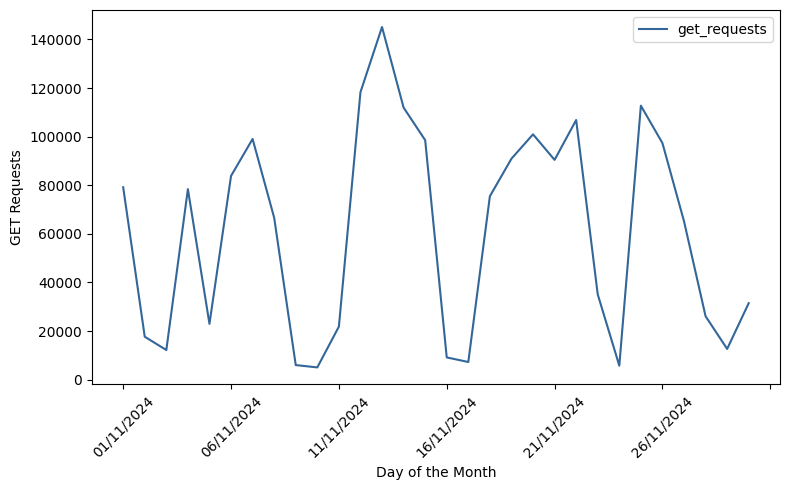

In [18]:
# plot the daily requests
total_daily_requests.plot(
    kind='line',
    x='formatted_date',
    y='get_requests',
    rot=45,
    color='#336699',
    figsize=(8,5)
).set(
    xlabel='Day of the Month',
    ylabel='GET Requests'
)

plt.tight_layout()  # Adjust layout to avoid overlapping labels
plt.show()          # Display the plot

### Who is using the data?
 
 - identify who uses the most
 - transform into a map

 For this part, we  will go use the `logs_filtered` dataframe because we want to capture all the users

In [19]:
# group by `remoteip` addresss to get users
users = logs_filtered.groupby('remoteip').size().sort_values(ascending=False).reset_index(name='requests')
print(users)
users.describe()

            remoteip  requests
0     205.204.186.54     70483
1    206.214.113.217     50692
2       65.34.44.229     50346
3     205.204.186.53     44784
4       96.29.41.191     39570
..               ...       ...
967     66.249.70.99         1
968  174.207.167.155         1
969      40.94.105.7         1
970    66.249.70.107         1
971     66.249.83.12         1

[972 rows x 2 columns]


,requests
count,972.00
mean,"1,886.82"
std,"5,625.34"
min,1.00
25%,20.00
50%,191.50
75%,975.75
max,"70,483.00"


#### Filter for variation

It looks like several users may have only tried the app once.  I'm going to set a minimum requests to 100 to only look at users  that have done more than just open the app.

In [20]:
users_filtered = users[users['requests'] >= 100]
print(users_filtered.describe())
users_filtered

       requests
count    587.00
mean   3,108.01
std    6,975.86
min      100.00
25%      239.50
50%      601.00
75%    2,294.00
max   70,483.00


,remoteip,requests
0,205.204.186.54,70483
1,206.214.113.217,50692
2,65.34.44.229,50346
3,205.204.186.53,44784
4,96.29.41.191,39570
...,...,...
582,208.102.249.228,101
583,192.69.180.163,101
584,198.102.32.250,100
585,174.202.64.247,100


### Get IP Address Geolocations

Sign up for a free account with [IPInfo](https://ipinfo.io/) to get an access token.

*This site may be blocked by your firewall or VPN.*

In [21]:
# ipinfo requirement: token and handler
access_token = 'bfa1fb799991f8'
handler = ipinfo.getHandler(access_token)

# create empty lists
latlng = []
city = []
region = []
postal = []

# loop through users_filtered to get location, city, region, and postal values
for ip_address in users_filtered['remoteip']:
    details = handler.getDetails(ip_address)
    # print(details.all)  # Show all available keys and values
    details_loc = details.loc
    latlng.append(details_loc)
    details_city = details.city
    city.append(details_city)
    details_region = details.region
    region.append(details_region)
    details_postal = details.postal
    postal.append(details_postal)

"""
Copy-on-Write will become the new default in pandas 3.0. This means that chained indexing will never work.
As a consequence, the SettingWithCopyWarning won’t be necessary anymore. See this section for more context.
 We recommend turning Copy-on-Write on to leverage the improvements with

` pd.options.mode.copy_on_write = True `

even before pandas 3.0 is available.
"""

pd.options.mode.copy_on_write = True 

# add output as columns
users_filtered['latlng'] = latlng
users_filtered['city'] = city
users_filtered['postal'] = postal

users_filtered

,remoteip,requests,latlng,city,postal
0,205.204.186.54,70483,"38.2009,-84.8733",Frankfort,40621
1,206.214.113.217,50692,"36.7417,-88.6367",Mayfield,42066
2,65.34.44.229,50346,"37.7006,-83.9738",Irvine,40336
3,205.204.186.53,44784,"38.2009,-84.8733",Frankfort,40621
4,96.29.41.191,39570,"38.1768,-85.5218",Louisville,40299
...,...,...,...,...,...
582,208.102.249.228,101,"38.9459,-84.6805",Union,41091
583,192.69.180.163,101,"38.0498,-84.4586",Lexington-Fayette,40505
584,198.102.32.250,100,"38.9187,-77.2311",Tysons,22027
585,174.202.64.247,100,"39.7684,-86.1580",Indianapolis,46204


#### Transform into a Geopandas DataFrame

In [22]:
# Assuming users_filtered is your existing dataframe and latlng is a column with lat,long values
# Convert latlng to Point geometries
geometry = [Point(map(float, loc.split(','))) for loc in users_filtered['latlng']]

# Convert the DataFrame to a GeoDataFrame
users_filtered_gdf = gpd.GeoDataFrame(users_filtered, geometry=geometry)

# Set a CRS (Coordinate Reference System), usually "EPSG:4326" for lat/lng
users_filtered_gdf.set_crs("EPSG:4326", inplace=True)

# Display the first 5 rows
print(users_filtered_gdf['geometry'].head(5))

0    POINT (38.2009 -84.8733)
1    POINT (36.7417 -88.6367)
2    POINT (37.7006 -83.9738)
3    POINT (38.2009 -84.8733)
4    POINT (38.1768 -85.5218)
Name: geometry, dtype: geometry


,objectsize,bytessent,totaltime
4880900,"249,161,895.00","190,423.00",175
5197329,"249,161,895.00","175,109.00",25
5154190,"249,161,895.00","155,374.00",25
5154191,"249,161,895.00","159,841.00",32
5197327,"249,161,895.00","175,321.00",100
...,...,...,...
6016112,NaN,350.00,5
6016113,NaN,350.00,8
6016114,NaN,350.00,6
6016115,NaN,350.00,6


#### Plot a map